In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
import json
# import torch.nn as nn
# import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
import pandas as pd

import warnings
warnings.filterwarnings('ignore')


seed = 1234
np.random.seed(seed)

g = torch.Generator()
g.manual_seed(seed)

In [8]:
# Load train data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)

# Load test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)




Files already downloaded and verified
Files already downloaded and verified


In [13]:
# Split load and validation set
X_tr, X_val, y_tr, y_val = train_test_split(trainset.data, trainset.targets, test_size=0.2, random_state=seed, shuffle=True)

# Set test data
X_te, y_te = testset.data, testset.targets

X_trShow = X_tr
X_valShow = X_val
X_teShow = X_te

# Flattern data to 2D array
X_tr = np.reshape(X_tr, (40000, 3072), order='C')
X_val = np.reshape(X_val, (10000, 3072), order='C')
X_te = np.reshape(X_te, (10000, 3072), order='C')

#Normalize
scaler = StandardScaler()
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)
X_val = scaler.transform(X_val)
X_te = scaler.transform(X_te)

X_tr, y_tr = X_tr[:20000], y_tr[:20000]

cv_results_f = open('cv_results.json')
cv_results = json.load(cv_results_f)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



In [27]:
# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()


# # get some random training images
# dataiter = iter(trainloader)
# images, labels = next(dataiter)

# # show images
# imshow(torchvision.utils.make_grid(images))
# # print labels
# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### KNN Classifier

In [33]:
#Train KNN Classifier
knn_parameters = {"n_neighbors": [1,3,5,10,100], "weights": ["uniform", "distance"]}
knn = KNeighborsClassifier()

gs_knn = GridSearchCV(knn,
                      param_grid=knn_parameters,
                      scoring='accuracy',
                      cv=5)
gs_knn.fit(X_tr, y_tr)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 10, 100],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [19]:
knn_results = cv_results["knn"] #json data
# knn_results = gs_knn.cv_results_ #actual run data

In [37]:
#Data visualization
#Declare columns
knn_table = pd.DataFrame(columns = ["Neightbors", "Weights", "Accuracy", "time"], dtype=object)

#Extract Data
for i in range(len(knn_results['mean_test_score'])):
    knn_table.loc[i] = [knn_results['params'][i]["n_neighbors"], knn_results['params'][i]["weights"], knn_results['mean_test_score'][i], knn_results["mean_fit_time"][i]]

#Sort data by accuracy
knn_table = knn_table.sort_values(by=['Accuracy'], ascending=False)
print(knn_table)

  Neightbors   Weights  Accuracy      time
5          5  distance   0.31985  0.254000
7         10  distance   0.31980  0.230799
3          3  distance   0.31350  0.241400
4          5   uniform   0.30890  0.229000
6         10   uniform   0.30885  0.225601
0          1   uniform   0.30725  0.226200
1          1  distance   0.30725  0.234001
2          3   uniform   0.29495  0.227800
9        100  distance   0.28445  0.231800
8        100   uniform   0.28110  0.228801


In [37]:
print(gs_knn.cv_results_)

{'mean_fit_time': array([0.2262002 , 0.23400059, 0.22780013, 0.24139957, 0.22900047,
       0.25400014, 0.22560139, 0.23079934, 0.22880063, 0.23180003]), 'std_fit_time': array([0.00865782, 0.00433554, 0.00611224, 0.00602041, 0.01075185,
       0.0456645 , 0.00621692, 0.0029254 , 0.00694094, 0.00943183]), 'mean_score_time': array([2.05139961, 1.94259925, 2.0497993 , 1.95000019, 1.95880041,
       1.85759921, 1.89819884, 1.7732008 , 1.9709991 , 1.91499968]), 'std_score_time': array([0.08173728, 0.0283175 , 0.06472274, 0.02948148, 0.08961065,
       0.14048501, 0.03257873, 0.03394895, 0.05991267, 0.06588548]), 'param_n_neighbors': masked_array(data=[1, 1, 3, 3, 5, 5, 10, 10, 100, 100],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_weights': masked_array(data=['uniform', 'distance', 'uniform', 'distance',
                   'uniform', 'distance', 'uniform', 'distance',
  

In [40]:
knn_best_param_zip = zip(knn_results["params"], knn_results["mean_test_score"])

knn_best_param = sorted(knn_best_param_zip, key = lambda x:x[1])[-1][0]

{'n_neighbors': 5, 'weights': 'distance'}


In [44]:

knn = KNeighborsClassifier(**knn_best_param)
knn.fit(X_tr, y_tr)
knn_y_predict =  knn.predict(X_te)


[ 0  4  5  6  7  8  9 10 11]
[4 8 8 0 4 2 6 2 2 8 2 8 4 6 8 8 4 2 8 5]
[3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6]


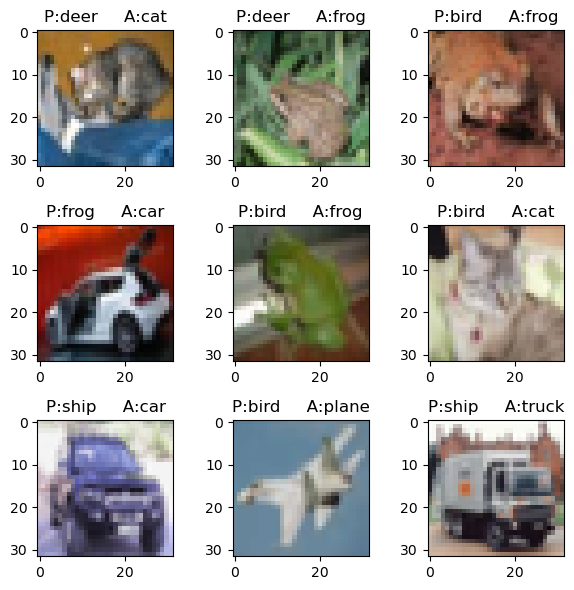

In [45]:
# Show error image
knn_error_index = np.where(knn_y_predict != y_te)[0][:9]
print(knn_error_index)

fig, axes = plt.subplots(3, 3, figsize=(6, 6))  
r, c = 0, 0
for image_index in knn_error_index:
    if r == 3:
        c += 1
        r = 0
    axes[c][r].imshow(X_teShow[image_index])
    axes[c][r].set_title(f'P:{classes[knn_y_predict[image_index]]}     A:{classes[y_te[image_index]]}')
    r += 1

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

fig.tight_layout()

### Logistic Regression

In [35]:
lgr_parameters = {'penalty':['l1', 'l2', 'elasticnet', 'none'],'C': [1, 2, 3]}
lgr = LogisticRegression(random_state=seed)
gs_lgr = GridSearchCV(lgr,
                      param_grid=lgr_parameters,
                      scoring='accuracy',
                      cv=5)
gs_lgr.fit(X_tr, y_tr)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=1234),
             param_grid={'C': [1, 2, 3],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none']},
             scoring='accuracy')

In [25]:
lgr_results = cv_results["lg"] #json data
# lgr_results = gs_lgr.cv_results_ #actual run data


In [26]:
#Data visualization

#Declare columns
lgr_table = pd.DataFrame(columns = ["Penalty", "Regularization", "Accuracy", "time"], dtype=object)

#Extract Data
for i in range(len(lgr_results['params'])):
    lgr_table.loc[i] = [lgr_results['params'][i]["penalty"], lgr_results['params'][i]["C"], float(lgr_results['mean_test_score'][i]), lgr_results["mean_fit_time"][i]]

#Sort data by accuracy
lgr_table = lgr_table.sort_values(by=['Accuracy'], ascending=False)
print(lgr_table)

       Penalty Regularization  Accuracy       time
1           l2              1   0.35820  11.463600
9           l2              3   0.35780  11.118600
5           l2              2   0.35765  11.391800
3         none              1   0.35585  11.170000
7         none              2   0.35585  11.628400
11        none              3   0.35585  11.016601
0           l1              1       NaN   0.161401
2   elasticnet              1       NaN   0.153801
4           l1              2       NaN   0.151800
6   elasticnet              2       NaN   0.149600
8           l1              3       NaN   0.139603
10  elasticnet              3       NaN   0.145802


In [38]:
print(gs_lgr.cv_results_)

{'mean_fit_time': array([ 0.16140056, 11.46360002,  0.15380054, 11.16999984,  0.1518002 ,
       11.39180017,  0.14959989, 11.62840033,  0.13960252, 11.11860013,
        0.14580212, 11.01660075]), 'std_fit_time': array([0.0055712 , 0.39480826, 0.01636399, 0.05102568, 0.01183935,
       0.33653775, 0.02177884, 0.84785285, 0.01712966, 0.10911415,
       0.01761197, 0.07175073]), 'mean_score_time': array([0.        , 0.02480092, 0.        , 0.02559924, 0.        ,
       0.02519965, 0.        , 0.02479897, 0.        , 0.02480059,
       0.        , 0.02480011]), 'std_score_time': array([0.        , 0.00040002, 0.        , 0.00049056, 0.        ,
       0.00074667, 0.        , 0.00074791, 0.        , 0.00074885,
       0.        , 0.00074809]), 'param_C': masked_array(data=[1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value='?',
            dtype=object), 'param_pe

### Decision Tree

In [39]:
dt_parameters = {'max_depth': [10,20,30],
            'min_samples_split': [20,10],
            'min_samples_leaf': [10,5]}

dt = DecisionTreeClassifier(random_state=seed)

gs_dt = GridSearchCV(dt,
                      param_grid=dt_parameters,
                      scoring='accuracy',
                      cv=5)
gs_dt.fit(X_tr, y_tr)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1234),
             param_grid={'max_depth': [10, 20, 30], 'min_samples_leaf': [10, 5],
                         'min_samples_split': [20, 10]},
             scoring='accuracy')

In [27]:
dt_results = cv_results["dt"] #json data
# dt_results = gs_dt.cv_results_ #actual run data

In [28]:
#Data visualization


#Declare columns
dt_table = pd.DataFrame(columns = ["max_depth", 'min_samples_split', 'min_samples_leaf', "Accuracy", "time"], dtype=object)

#Extract Data
for i in range(len(dt_results['params'])):
    dt_table.loc[i] = [dt_results['params'][i]["max_depth"], dt_results['params'][i]["min_samples_split"], dt_results['params'][i]["min_samples_leaf"], dt_results['mean_test_score'][i], dt_results["mean_fit_time"][i]]

#Sort data by accuracy
dt_table = dt_table.sort_values(by=['Accuracy'], ascending=False)
print(dt_table)

    max_depth  min_samples_split  min_samples_leaf  Accuracy       time
0        10.0               20.0              10.0   0.27895  28.831000
1        10.0               10.0              10.0   0.27895  28.518201
2        10.0               20.0               5.0   0.27685  28.904607
3        10.0               10.0               5.0   0.27555  28.852400
8        30.0               20.0              10.0   0.26455  36.048399
9        30.0               10.0              10.0   0.26455  36.052999
4        20.0               20.0              10.0   0.26405  36.323809
5        20.0               10.0              10.0   0.26405  36.212401
6        20.0               20.0               5.0   0.25855  38.720600
10       30.0               20.0               5.0   0.25800  38.943737
11       30.0               10.0               5.0   0.25500  40.699801
7        20.0               10.0               5.0   0.25475  39.749400


In [42]:
print(gs_dt.cv_results_)

{'mean_fit_time': array([28.8309998 , 28.51820054, 28.90460734, 28.85240006, 36.32380891,
       36.21240139, 38.72059951, 39.74940047, 36.04839931, 36.05299897,
       38.94373741, 40.6998013 ]), 'std_fit_time': array([0.32396137, 0.03399701, 0.16112171, 0.10137854, 0.18682766,
       0.20367114, 0.16025985, 0.11869655, 0.26467031, 0.24820064,
       0.31313281, 0.56209888]), 'mean_score_time': array([0.03319979, 0.03440056, 0.03179321, 0.03099971, 0.03360085,
       0.03239851, 0.03280025, 0.03360004, 0.03500061, 0.0312006 ,
       0.0302    , 0.03659968]), 'std_score_time': array([0.00318799, 0.0018538 , 0.00159903, 0.00089463, 0.00326182,
       0.0014955 , 0.00231605, 0.00119963, 0.0048167 , 0.00116713,
       0.00039995, 0.00387892]), 'param_max_depth': masked_array(data=[10, 10, 10, 10, 20, 20, 20, 20, 30, 30, 30, 30],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value='?',
            dtyp

### Neural Network

In [29]:
mlp_parameters = {'hidden_layer_sizes': [(100, 100)],
                  'alpha':[0.0001, 0.001, 0.01],
                  'max_iter': [100,200,300]}
mlp = MLPClassifier(random_state=seed)


gs_mlp = GridSearchCV(mlp,
                      param_grid=mlp_parameters,
                      scoring='accuracy',
                      cv=5)
gs_mlp.fit(X_tr, y_tr)

GridSearchCV(cv=5, estimator=MLPClassifier(random_state=1234),
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(100, 100)],
                         'max_iter': [100, 200, 300]},
             scoring='accuracy')

In [29]:
mlp_results = cv_results["mlp"] #json data
# mlp_results = gs_mlp.cv_results_ #actual run data

In [30]:
#Data visualization

#Declare columns
mlp_table = pd.DataFrame(columns = ["hidden_layer_sizes", "alpha", 'max_iter' ,"Accuracy"], dtype=object)

#Extract Data
for i in range(len(mlp_results['params'])):
    mlp_table.loc[i] = [mlp_results['params'][i]["hidden_layer_sizes"], mlp_results['params'][i]["alpha"], mlp_results['params'][i]["max_iter"], mlp_results['mean_test_score'][i]]

#Sort data by accuracy
mlp_table = mlp_table.sort_values(by=['Accuracy'], ascending=False)
print(mlp_table)

  hidden_layer_sizes   alpha max_iter  Accuracy
7         (100, 100)  0.0100      200   0.44220
8         (100, 100)  0.0100      300   0.44220
6         (100, 100)  0.0100      100   0.43950
3         (100, 100)  0.0010      100   0.43605
4         (100, 100)  0.0010      200   0.43605
5         (100, 100)  0.0010      300   0.43605
0         (100, 100)  0.0001      100   0.43565
1         (100, 100)  0.0001      200   0.43565
2         (100, 100)  0.0001      300   0.43565


In [32]:
print(gs_mlp.cv_results_)

{'mean_fit_time': array([158.79577718, 145.43309855, 133.33613429, 118.89626675,
       120.87812419, 122.31078115, 151.40250211, 168.98954415,
       178.39873843]), 'std_fit_time': array([34.96888354, 16.03377153, 23.55980315, 16.96540862, 17.67141635,
       18.15326718, 23.88270087, 40.12326359, 34.44005075]), 'mean_score_time': array([0.06860056, 0.05900011, 0.05419936, 0.05260057, 0.0517993 ,
       0.05419998, 0.05280066, 0.05599957, 0.06180005]), 'std_score_time': array([0.01467776, 0.0076683 , 0.00231566, 0.00174395, 0.00231376,
       0.00331042, 0.00146981, 0.0030335 , 0.00617647]), 'param_alpha': masked_array(data=[0.0001, 0.0001, 0.0001, 0.001, 0.001, 0.001, 0.01,
                   0.01, 0.01],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_hidden_layer_sizes': masked_array(data=[(100, 100), (100, 100), (100, 100), (100, 100),
                   (100, 100), (100

In [1]:
import numpy as np

In [2]:
val = {'mean_fit_time': np.array([135.7800457 , 138.32399549, 151.20578947]),
       'std_fit_time': np.array([27.58550604, 25.59174489, 38.5174153 ]),
       'mean_score_time': np.array([0.05100017, 0.05060196, 0.0508007 ]),
       'std_score_time': np.array([0.00419493, 0.00313741, 0.00278526]),
       'param_alpha': np.ma.masked_array(data=[0.01, 0.01, 0.01], mask=[False, False, False], fill_value='?',dtype=object),
       'param_hidden_layer_sizes': np.ma.masked_array(data=[(100,), (100, 100), (100, 100, 100)], mask=[False, False, False], fill_value='?', dtype=object),
       'param_max_iter': np.ma.masked_array(data=[200, 200, 200], mask=[False, False, False], fill_value='?', dtype=object),
       'params': [{'alpha': 0.01, 'hidden_layer_sizes': (100,), 'max_iter': 200},
                  {'alpha': 0.01, 'hidden_layer_sizes': (100, 100), 'max_iter': 200},
                  {'alpha': 0.01, 'hidden_layer_sizes': (100, 100, 100), 'max_iter': 200}],
       'split0_test_score': np.array([0.41625, 0.447  , 0.43125]),
       'split1_test_score': np.array([0.437  , 0.44225, 0.43225]),
       'split2_test_score': np.array([0.442 , 0.4475, 0.4445]),
       'split3_test_score': np.array([0.4355 , 0.42875, 0.4365 ]),
       'split4_test_score': np.array([0.4425, 0.4455, 0.4345]),
       'mean_test_score': np.array([0.43465, 0.4422 , 0.4358 ]),
       'std_test_score': np.array([0.00959635, 0.00697029, 0.0047154 ]),
       'rank_test_score': np.array([3, 1, 2])}
val2 = {'mean_fit_time': np.array([102.67339687, 223.10058417, 188.27551398, 253.87526402]),
        'std_fit_time': np.array([ 7.36848387, 54.23335041, 39.65138141, 75.99398704]),
        'mean_score_time': np.array([0.05040007, 0.07539911, 0.07660084, 0.09001145]),
        'std_score_time': np.array([0.01348503, 0.013215  , 0.00332344, 0.00523298]),
        'param_alpha': np.ma.masked_array(data=[0.01, 0.01, 0.01, 0.01], mask=[False, False, False, False], fill_value='?',dtype=object),
        'param_hidden_layer_sizes': np.ma.masked_array(data=[(50, 50), (150, 150), (200, 200), (250, 250)], mask=[False, False, False, False, False, False, False, False], fill_value='?', dtype=object),
        'param_max_iter': np.ma.masked_array(data=[200, 200, 200, 200], mask=[False, False, False, False], fill_value='?',dtype=object),
        'params': [{'alpha': 0.01, 'hidden_layer_sizes': (50, 50), 'max_iter': 200},
                   {'alpha': 0.01, 'hidden_layer_sizes': (150, 150), 'max_iter': 200},
                   {'alpha': 0.01, 'hidden_layer_sizes': (200, 200), 'max_iter': 200},
                   {'alpha': 0.01, 'hidden_layer_sizes': (250, 250), 'max_iter': 200}],
        'split0_test_score': np.array([0.39975, 0.4405 , 0.46075, 0.474  ]),
        'split1_test_score': np.array([0.40475, 0.468  , 0.45225, 0.47475]),
        'split2_test_score': np.array([0.40425, 0.4525 , 0.46525, 0.473  ]),
        'split3_test_score': np.array([0.396  , 0.45775, 0.43175, 0.4855 ]),
        'split4_test_score': np.array([0.40325, 0.44275, 0.469  , 0.4755 ]),
        'mean_test_score': np.array([0.4016 , 0.4523 , 0.4558 , 0.47655]),
        'std_test_score': np.array([0.0033    , 0.01006653, 0.01325934, 0.00455082]),
        'rank_test_score': np.array([4, 3, 2, 1])}


In [3]:
import matplotlib.pyplot as plt


In [4]:
arrx = [o for o in val["mean_fit_time"]]
arry = [t for t in val["mean_test_score"]]
labels = ["(100,)", "(100, 100)", "(100, 100, 100)", "(50, 50)", "(150, 150)", "(200, 200)", "(250, 250)"]
for o, t in zip(val2["mean_fit_time"], val2["mean_test_score"]):
    arrx.append(o)
    arry.append(t)
arrx = np.array(arrx)
arry = np.array(arry)

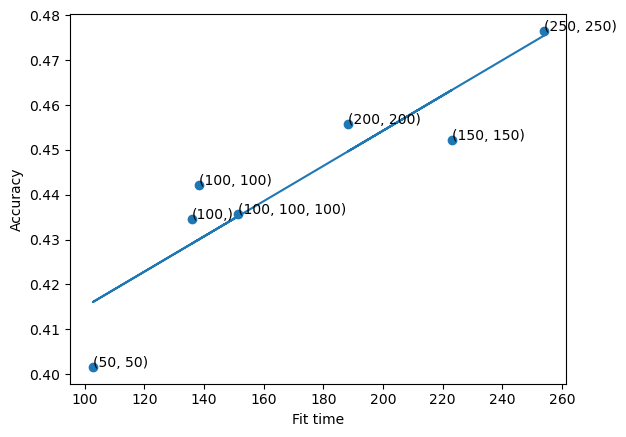

In [5]:
fig, axes = plt.subplots()
axes.set_xlabel("Fit time")
axes.set_ylabel("Accuracy")
axes.scatter(arrx, arry)
for i in range(len(arrx)):
    axes.annotate(labels[i], (arrx[i], arry[i]))
a, b = np.polyfit(arrx, arry, 1)
axes.plot(arrx, a*arrx + b)